# K-Means Implementation from scratch | Python

## Clustering with K-Means

K-Means is one of the most popular "clustering" algorithms, which you perhaps are already familiar with from the Data Mining curricular unit. K-means estimates the location of $k$ centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.

The K-means Algorithm consists in an iterative process that is roughly as follows:
1. Choose value for K (number of clusters);
2. Initialize the locations of the centroids, which we can do by randomly select K points from your dataset as initial locations of the centroids;
3. Calculate distance of all other points to each of the K centroids;
4. Associate each point to the cluster of the closest centroid;
5. Update the centroid position, by computing the average coordinates of all points associated to each cluster;
6. Evaluate the average change in the centroids positions, as a measure of convergence (the algorithm is said to have converged to the solution when the positions of the centroids don't change more than a given tolerance threshold);
7. Repeat steps 3-6 until either the centroids no longer move more than a tolerance threshold or until you repeated these steps at least for specified number of iterations (niter)

The algorithm is thus parametized by the number of clusters (K), the maximum number of iterations (niter), and the tolerance threshold (tol).

### Step 1

Let us start by importing the necessary libraries to execute this homework. <br>
Import numpy, Scipy, and pandas using, respectively, the aliases np, sc, and pd. <br>
Note that these are the only libraries you are allowed to use throughout the assignment, unless it is explicitly said you should use a different one.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm #just for visualizing how long the excecution of the for loop takes when finding the best seed.

It is important that we devise a strategy to test our code at each step, in order to assess if it performs as expected. To that end, we have split each step of the algorithm into different blocks, and we ask you to test each block against a simple scenario where the outcome is predictable and can be computed by hand. In some steps, however, we want to pass a more comprehensive dataset with similar properties to the real dataset that we will be working with.<br>

Such, test datasets try to create realistic conditions in which your algorithm is expected to work correctly, and for which we can also assess if the solution matches our expectation. This allows us to have a general understanding if the algorithm performs as expected in "real-world" conditions.<br>

For this homework we will resort to a dataset that contains two clearly distinct clusters. We generated the clusters by sampling points from two distinct gaussian distributions with different averages and same standard deviation. As such, our algorithm should be able to identify each cluster easily, and place the centroids close to the averages of the two distributions. <br>

Run the cell below to download, load the data into a numpy array, and then get a visual representation of the Test dataset.<br>
You will run your algorithm implementation against this dataset as a proof of work.

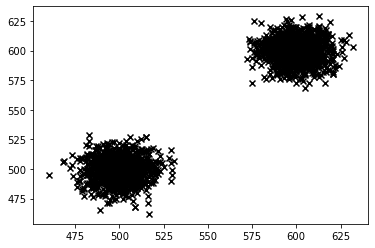

In [2]:
# download the file into a dataframes and convert it to a numpy array.

data_test = pd.read_csv("https://www.dropbox.com/s/gax1l68jsarxqt9/data_test.txt?dl=1", header=None).to_numpy()

#plot the points into a scatter plot
plt.scatter(data_test[:, 0], data_test[:,1], color ='k', marker='x')
plt.show()

<b>Optional Challenge:</b> Can you write a function that generates an artificial dataset for testing purposes?<br>
We will award one extra point for students that offer a good implementation.

**Consider leaving this challenge to the very end of the assignment**

In [3]:
def create_testset(k,s,mean,sigma):
    
#k: number of clouds
#s: number of data points per cloud
#mean: x and y coordinate of the center of the first cloud
#sigma: deviation from the mean
    d=2 #set dimension to 2 in order to creat a 2D Clustering problem
    mean = np.random.randint(20,600) #Initializing the the mean (x and y coordinate of the center of first cloud)
    cloud = np.random.normal(mean,sigma,size=(s, d)) #create the first cloud
    
    for i in range(k-1): #add k-1 more clouds to the cloud created before
        mean += np.random.randint(100,600) #increase the mean by a random number, since I dont want to have all clouds with the came center.
        cloudtoadd = np.random.normal(mean,sigma,size=(s, d))
        coordinates = np.random.randint(0,d) #randomly select y or x coordinate (1 or 0)
        cloudtoadd[:,coordinates] = cloudtoadd[:,coordinates] + np.random.randint(200,2000) #because of numpy broadcasting this operation works. Add a random number to either all x or y coordinates of all points in the cloud, to not have all clouds on the diagonal.
        cloud = np.concatenate((cloud, cloudtoadd)) #add created cloud to the ones created before.
    return cloud

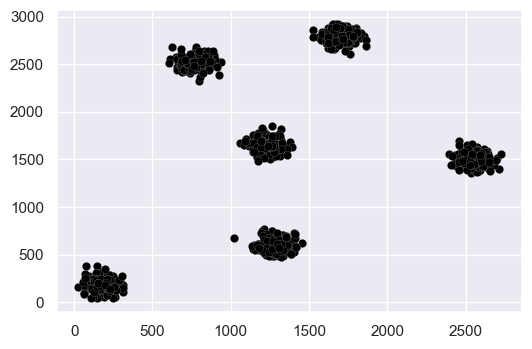

In [39]:
test = create_testset(6,200,150,60) #test my fuction
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.scatterplot(x=test[:,0],y=test[:,1],color="black",linewidth=0.1) #plot result
plt.show()

### Step 2 

Write a function named <b>init</b> that takes two arguments: $points$ and $K$. <br>
The function <b>init</b> should return a numpy ndarray with  $K$ elements sampled randomly and without repetitions from $points$. Meaning, the same point should not be picked up twice. <br>

**Show that your function performs as desired by calling it with** $K = 2$ **and using $data\_test$ as the** $points$

In [5]:
def init(points,K):
    index = np.random.choice(points.shape[0], K, replace=False) #replace=False makes sure no point will be drawn twice
    return points[index]
init(data_test,2)

array([[492, 493],
       [608, 614]])

### Step 3

Write a function named <b>distance</b> that takes two arguments: $p1$ and $p2$. <br>
The function <b>distance</b> should return a scalar that corresponds to the euclidean distance between points $p1$ and $p2$. <br> 
We assume that $p1$ and $p2$ are two ndarrays of the same size.

Recall that the euclidian distance (d) between two points ($p_1$ and $p_2$) in a 2-dimensional space is given by:<br><br>
\begin{equation}
    d(p_1, p_2) = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2 }
\end{equation}<br>
where $p_1 = \{x_1,y_1\}$ and  $p_2 = \{x_2,y_2\}$. <br>


**1) Test that your function works by computing the distance between p1=(1,3) and p2=(7,2), which is $\approx$ 6.08.**<br>
**Consider using the existing Numpy or Scipy packages for this task.**

Can you write a function that computes the euclidean distance between two points of arbitrary dimension? <br>
In general, for arbitrary dimensionality the square of the distance can be computed as:<br><br>
\begin{equation}
    d^2(p_1, p_2) = \sum_{i=0}^{D-1} (x_i-y_i)^2
\end{equation}<br>
where $p_1 = \{x_1,x_2,...,x_{D-1}, x_D\}$ and $p_2 = \{y_1,y_2,...,y_{D-1},y_D\}$.<br>

**2) Show that your function works by computing the distance between (1,3,-9,12) and (7,2,0,5)**

***1)***

In [6]:
def distance(p1,p2):
    return np.linalg.norm(p1-p2) 
#The euclidean distance can be calculated by computing the L2 norm which is the default outcome of numpys linalg.norm function 

In [7]:
#Test variables, do not change the values
p1 = np.array([1,3])
p2 = np.array([7,2])
distance(p1,p2)

6.082762530298219

***2)***

In [8]:
#Test variables, do not change the values
p1 = np.array([1,3,-9,12])
p2 = np.array([7,2,0,5])

In [9]:
distance(p1,p2)

12.922847983320086

### Step 4

Write a function <b>centroid_update</b> that takes two input arguments: <i>points</i> and <i>clusters</i><br> 
The argument <i>points</i> is a ndarray containing the coordinates of a set of points (1 point per row).
The argument <i>clusters</i> is a 1-dimensional ndarray that indicates the cluster to which each point is associated.
Note that values in <i>clusters</i> are integers and can only take values between 0 and K-1, where K is the number of clusters.

The function <b>centroid_update</b> should return an ndarray with the average coordinates of the points associated to each cluster, that is the centroid of each cluster. The returned array should have the same number of columns as dimensions (i.e., coordinate in your problem) and K rows. Meaning that each row will indicate the coordinates of a centroid.

**Test your function and report the centroids generated by passing p and c as inputs with k = 3. Save these centroids as a variable: cen**

In [10]:
def centroid_update(points,clusters):
    df = pd.DataFrame(points)
    df["Cluster"]=clusters
    return df.groupby("Cluster").mean().to_numpy() #use pandas groupby method to find the mean of x and y coordinates of each cluster respectively.

In [11]:
# Test variables, do not change the values
p = np.array([[0.8922063, 0.26672425],[0.34475611, 0.35976697],[0.33253499, 0.18923898],[0.66872466, 0.46248986],[0.72823733, 0.10537784],[0.40903598, 0.70639412],[0.79926596, 0.90095583],[0.67886544, 0.84573289],[0.3641813, 0.64296743],[0.07461196, 0.74290527]])
c = np.array([2, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [12]:
cen = centroid_update(p,c)
print(cen)

[[0.44995487 0.55986467]
 [0.53760985 0.53912646]
 [0.8922063  0.26672425]]


### Step 5

Write a function <b>points_update</b> that takes two input arguments: $points$ and $centroids$.<br>
The function <b>points_update</b> should return a one-dimensional ndarray that indicates the index of the centroid that is closer to each point. To determine the distance between a centroid and a point you can use your distance function you created earlier. <br>

You will need to assess the distance between each point to each centroid. Different approaches can be taken to do this. For instance, you can start by computing a matrix with the all the distances between each of the $d$ points and the $k$ centroids, but there are more efficient approaches.

**Test your function by calling it and passing the array p (as defined above) with the output of centroids_update, cen, as arguments. You should get an output that looks like c, as defined above, but not exactly the same, can you see why?. Print this result and save it in a variable called new_clusters**

In [13]:
def points_update(points,centroids):
    return sc.spatial.distance.cdist(centroids, points).argmin(axis=0) 
#Used the highly efficient distance matrix function of scipy. The matrix includes the distance form each point to each centroid.
#By calculating the minimums of each column I obtain the distances of each point to its nearest centroid 
#.argmin returns the index of the minimum value which gives me the cluster the point belongs to.
#By default sc.spatial.distance.cdist computes the euclidean distance

In [14]:
new_clusters = points_update(p,cen)
print(new_clusters)
#The result is sightly different now because we updated/optimized the location of the centroids. So some points are closer to a different centroid now.

[2 0 0 1 2 0 1 1 0 0]


### Step 6

Write a function <b>error</b> that takes two input arguments: oldcentroids and newcentroids.<br>
The argument oldcentroids corresponds to a ndarray with centroid positions from the previous iteration, and newcentroids to a ndarray with the newly computed centroid positions from the current iteration. <br>

The function <b>error</b> should return the average euclidian distance between the old and new positions of each centroid. We will use the function error to obtain an estimate of whether the algorithm is still converging to the solution (that is the centroids are, in average, moving a lot) or if we entered a scenario of small steps (that is the centroids are, in average, not moving that much). In that sense, the name of the function (error) is not entirely accurate but fullfills the purpose. We will use this information combined with a tolerance threshold in regards to the average change in the centroids positions to decide if it is a good time to stop the algorithm.

**Test your function then report the distance between the centroids calculated in Step 5, cen, and the centroids that you can calculate using the function cupdate with the arguments points and new_clusters.**

In [15]:
def error(oldcentroids,newcentroids):
    #dist gives me a distance matrix with the distances from each new centroids to each old centroid.
    #It is only of interest how much each centroid moves so I can ignore the distances between new and old locations of different centroids.
    #The diagonal of dist gives me the distance between the old location and new location of the same centroid .
    dist=sc.spatial.distance.cdist(oldcentroids, newcentroids)
    return np.diagonal(dist).mean()
    
    #One could argue that Im wasting computational power by computing distances that are not used but sc.spatial.distance.cdist is so well optimized that it is still perfoming better than any for-loop solution.
error(cen,centroid_update(p,new_clusters))

0.17635560837965428

### Step 7

Write a wrapper function called <b>kmeans</b> that takes the following arguments:
- $points$, which is a ndarray of points;
- $K$, the number of clusters, set the default value to two;
- $niter$, the number of iterations;
- $tol$, the error tolerance threshold below which your algorithm should stop

The function should return:
- A one dimensional ndarray with the cluster that each point is associated to,
- A ndarray with the location of the K centroids.

Use the functions you prepared in the previous Steps to assemble the function <b>kmeans</b>. <br>
Use the tolerance as a treshold to stop the algorithm, for instance by evaluating if the average variation in the distance between the new and previous coordinates of the centroids is below the tolerance level. If yes, then you can stop the algorithm and return the outputs. <br>

**Note: A common issue with the K-means algorithm is that in some limiting conditions it might lead to empty clusters. In that case it is expected that your algorithm to return errors. Although that is not expected to happen with the examples provided, you might want to consider implementing some heuristics to overcome those errors. However, such is an optional task, and for this homework if you bump into such errors we recommend you try to rerun your code.**

In [16]:
def kmeans(points,niter,tol,seed,K=2):
    np.random.seed(seed)   #I included seed in kmeans to remove noise due to randomness of centroid initialization when comparing different values of K. Please see step 9.
    location_cen=init(points,K)  #Randomly pick K points and make them the initial location of the centroids.
    errors= tol+1   #Initializing erros with a value greater than tol to make sure the loop doesnt break in the very first iteration.
    cluster_of_points = points_update(points,location_cen) #Assign a cluster to each point depending on which cendroid the point is closest to

    for i in range(niter):
        if errors < tol:
            break
        oldcentroids = np.copy(location_cen) #Use .copy to make sure not to have any binding between oldcentroids and location_cen.
        location_cen = centroid_update(points,cluster_of_points) #Update/optimize centroid location
        cluster_of_points = points_update(points,location_cen) #Assign clusters to each point depending on which centroids they are nearest to.
        errors = error(oldcentroids,location_cen) #Compute how much the centroid location has moved, if the movement is tiny we break the loop in the next iteration
        
        return cluster_of_points,location_cen

In [17]:
cluster_of_points,location_cen = kmeans(data_test,500,0.00001,1234)
print(cluster_of_points,location_cen)

[0 0 0 ... 1 1 1] [[499.65527344 498.94433594]
 [599.49853372 599.63538612]]


It is useful to visually inspect the results in order to assess the performance of the clustering algorthim. <br>
Below is an example of how you can visualize your results for a sample dataset. <br>
Can you adapt the code to show your results applied to data_test with K = 2, niter = 500, tol = 0.00001.

<span style="color:red">**In this step feel free to use any other visualization library such as Seaborn.**</span>

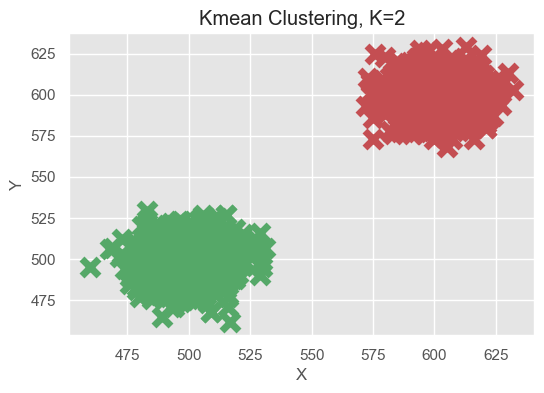

In [18]:
#boilerplate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
# let us define the style of the plot here
style.use('ggplot')
colors = ["g","r","c","b"]

# plot each point in the centroids array
for centroid in location_cen:
    plt.scatter(centroid[0],centroid[1], marker="o", color="k", s=150, linewidths=5)

# plot each point in the points array, colored according to the cluster they belong
for i in range(len(cluster_of_points)):
    plt.scatter(data_test[i,0],data_test[i,1], marker="x", color=colors[cluster_of_points[i]], s=150, linewidths=5)
    
plt.title("Kmean Clustering, K=2")
plt.xlabel("X")
plt.ylabel("Y")

# plot all elements
plt.show()

### Step 8

Write a function <b>inertia</b> that takes three input arguments: $points$, $clusters$, and $centroids$.<br>
Where $points$ is an 2-dimensional ndarray with the coordinates of each point in your dataset, clusters is a vector that indicates the cluster of each point (takes values between $0$ and $K-1$), and $centroids$ is a 2-dimensional ndarray with length $k$ of the coordinates of the centroids.

The function should return a tuple in which the first value is the number of clusters and the second is the computed **average squared Euclidean distance** of the points to the centroid of the cluster they are assigned.
The Squared of the Euclidean distance is a common measure of error that satisfies several important properties, namely it is strictly convex and smooth. It is often used in the method of Least Squares to fit linear functions to data, in which we try to find the parameters of a linear model that minimize the average of the square distances between the observed values and the values predicted by the fitted model. Here we are borrowing these concepts to measure the dispersion of points in a cluster, in other words, the error between the position of the centroid and the locations of the points associated with it.


**Test your function and report the results of using point=p, clusters=c, and centroids=cen. These are the variables that you have used in the previous steps**
**Note: distance always refers to the euclidean distance.**

In [19]:
def inertia(points,clusters,centroids):
    number_clusters= np.unique(clusters).size  #One could also take the length of cenroids but this wouldnt account for potential empty clusters. So thats why I check for clusters that are actually have points assigned to.
    average_distance = np.square(sc.spatial.distance.cdist(centroids, points).min(axis=0)).mean() #Find for each point the distance to the nearest cendroid (each point is located in cluster with the nearest centroid). Then square all distances, and take the mean.
    return number_clusters, average_distance

In [20]:
inertia(p,c,cen) #My result might be different from the results of others because my function uses the distance from the points to the new centroids to find out which cluster a point belongs to. Others might have taken the old c instead.


(3, 0.08033790687112305)

### Step 9

Load the data from file https://www.dropbox.com/s/wco3lxgn1f4a5k2/data_custering.csv?dl=1 into numpy array.<br>
The data consists of the coordinates of $N$ points in a 2-dimensional space. <br>
Use the functions <b>kmeans</b> and <b>internia</b> to identify the most suitable number of clusters. <br>
You might want to consider doing some visual inspection and reporting with matplotlib and seaborn.<br>
For instance, inspect visually the dataset before performing the clustering; report the inertia values as a line plot; show the result of your clustering.

Tip: use the output of inertia to perform the elbow method https://en.wikipedia.org/wiki/Elbow_method_(clustering).

In [21]:
loaded_data = pd.read_csv("https://www.dropbox.com/s/wco3lxgn1f4a5k2/data_custering.csv?dl=1", header=None).to_numpy()

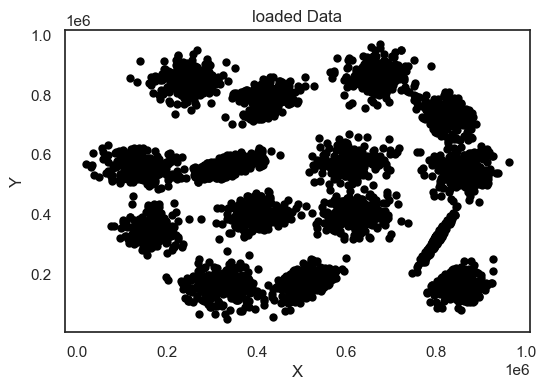

In [22]:
sns.set_theme(style="white") #This theme looks better
sns.scatterplot(x=loaded_data[:,0],y=loaded_data[:,1],marker="o",linewidth=0,color="black")
#Plot loaded data
plt.xlabel("X")
plt.ylabel("Y")
plt.title("loaded Data")
plt.show()

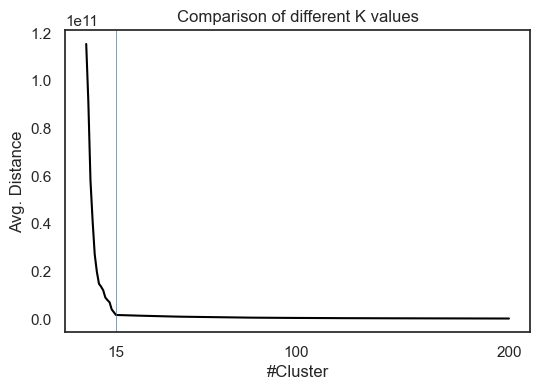

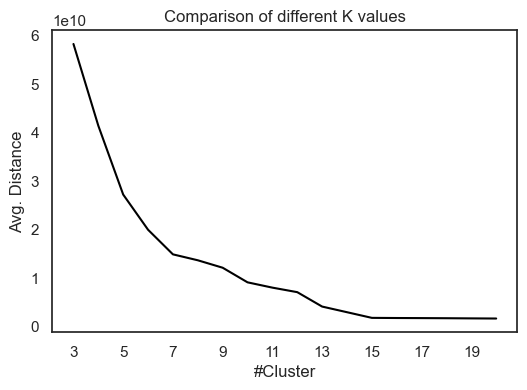

In [23]:
coordinates = []
seed = 580761 # use seed to make reuslts for different values of k compareable.
ite=200 #try kmeans from k=1 to k=200
for i in range(ite):
    c, cen = kmeans(loaded_data,500,0.00001,seed,i+1)
    add=inertia(loaded_data,c,cen)
    coordinates.append(add) #save the returns of k means in the list coordinates
df = pd.DataFrame(coordinates,columns = ["#Cluster","Avg. Distance"]) #convert it to a dataframe in order to not need to label the axis manually.
plt.figure(2)
sns.lineplot(x=df["#Cluster"],y=df["Avg. Distance"],color="black")#Use seaborn to plot the output of the inertia function
K=15
plt.axvline(x=K,linewidth=0.5) #Visualize the optimal value of K with a vertical line
plt.xticks([K, ite/2, ite]) #make sure there is a tick at the optimal value of K
plt.title("Comparison of different K values")
plt.show()
plt.figure(0) #Creating new figure
sns.lineplot(x=df["#Cluster"][2:20],y=df["Avg. Distance"][:20],color="black") #To better visualize the elbow point I change the range of the graph that I plot
plt.title("Comparison of different K values")
plt.xticks(range(3,21,2))
plt.show()

#The graph is not entirely convex and has at least two concave intervals. Hence, the elbow point cannot be calculated.
#From the visualization of points and from elbow graph K=15 can be assumed to be the optimal number of clusters. K=15 is a good approximation for  the alobow point.

In [24]:
def find_best_seed(data,K):
    Avg_dis=[]
    seeds=[]
    for i in tqdm(range(10000)):    
        seed = np.random.randint(2**32 - 1) #2**32-1 is the maximum seed value
        cluster_of_points,location_cen= kmeans(data,500,0.00001,seed,K)
        Avg_dis.append(np.square(sc.spatial.distance.cdist(location_cen,data).min(axis=0)).mean()) #store distance as performance measurement of the seed in list
        seeds.append(seed)    #store seed in list  
    index=Avg_dis.index(min(Avg_dis)) #index of best seed
    print(f"The best seed value that could be found is: {seeds[index]}")
    return seeds[index]  
seed = find_best_seed(loaded_data,15)

#I built this function to find the optimal value of seed, corresponding to a specific choice of K points as initial cendroids.
#It randomly chooses a seed and computes the corresponding Avg. Sqaured distance between the resulting centroids and the points
#The seed leading to the minimal avg. squared distance is the best seed that cound be found.
#Please notice that the best choice of seed depends on the data set. For a different data set a totally different seed might be better.
#Also this algorithm might be computationally slow compared to K++, however I would like to keep the initialization random, as demanded by the task. 
#I just run the init-function many times and take the initalization that fits the clustering problem best.

  0%|          | 0/10000 [00:00<?, ?it/s]

The best seed value that could be found is: 2158556745


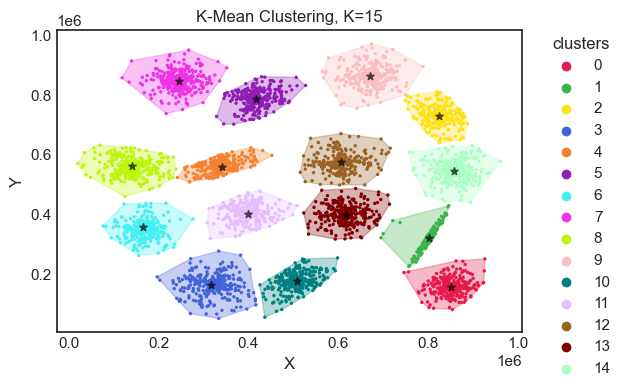

In [25]:
K=15
plt.style.use('seaborn-white')

#by default seaborns color palette only include 12 distinct colors and I dont want to use sequential color palettes, so I create a list with 19 high contrast hex codes to use them to vizualize different clusters.
hexcode=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

seed = 580761  #I ran the algorithm in the cell above for 10 milion iterations and the best performing seed was 580761. Corresponding to a specific choice of 15 points when initializing the cendroids.
plt.figure(4)
c, cen = kmeans(loaded_data,600,0.00001,seed,K)
sns.scatterplot(x=loaded_data[:,0],y=loaded_data[:,1],hue=c,marker="o",palette=hexcode[:K],linewidth=0,s=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title="clusters") #Place legend outside the graph
plt.xlabel("X")
plt.ylabel("Y")
plt.title("K-Mean Clustering, K=15")
plt.scatter(cen[:,0],cen[:,1], marker='*', s=30,color="black") #vizualize the cenroids

# Draws a line around each cluster:

from scipy.spatial import ConvexHull
for cluster in range(K):
    cpoints = loaded_data[sc.spatial.distance.cdist(cen,loaded_data).argmin(axis=0)==cluster] #gets all points of cluster of this iteration
    
    chull = ConvexHull(cpoints) #create a convex hull
    x_hull = np.append(cpoints[chull.vertices,0],
                       cpoints[chull.vertices,0][0])
    y_hull = np.append(cpoints[chull.vertices,1],
                       cpoints[chull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.3, c=hexcode[cluster]) #use the list hexcode defined above
plt.show()